In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

df = pd.read_csv('data.csv', names=['date', 'co2', 'temperature', 'humidity'], skiprows=1)
df['date'] = pd.to_datetime(df['date'])
df = df[['date', 'temperature']]
df


,date,temperature
0,2023-03-24 14:23:00,21.63
1,2023-03-24 14:24:00,20.63
2,2023-03-24 14:25:00,20.29
3,2023-03-24 14:26:00,20.22
4,2023-03-24 14:27:00,20.23
...,...,...
17638,2023-04-05 20:17:41,21.72
17639,2023-04-05 20:18:41,21.77
17640,2023-04-05 20:19:40,21.76
17641,2023-04-05 20:20:40,21.79


In [54]:
# Preprocessing

scaler = MinMaxScaler(feature_range=(0, 1))
df['temperature'] = scaler.fit_transform(df['temperature'].values.reshape(-1,1))
df.set_index('date', inplace=True)
df.dropna(inplace=True)

def prepare_dataset(df, look_back: int):
    XS = []
    YS = []
    for i in range(len(df)-look_back):
      x = df.iloc[i:(i+look_back)].values
      y = df.iloc[i+look_back]
      XS.append(x)
      YS.append(y)
    return np.array(XS), np.array(YS)

X, Y = prepare_dataset(df, 60) # 60 minutes

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32).view(-1, 1)

X.shape, Y.shape

(torch.Size([17583, 60, 1]), torch.Size([17583, 1]))

In [55]:
# LSTM Model

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        size = x.size(0)
        h0 = torch.zeros(self.num_layers, size, self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, size, self.hidden_dim).requires_grad_()
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [56]:
# Model and Parameters Init
dataset = TensorDataset(X, Y)
batch_size = 64
data_loader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
model = LSTMModel(input_dim=1, hidden_dim=50, num_layers=2, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [57]:
# Training loop

def training_loop(num_epochs: int) -> None:
  for epoch in range(num_epochs):
      for inputs, labels in data_loader:
          optimizer.zero_grad()
          outputs = model(inputs)  
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
      print(f'Epoch {epoch+1}, Loss: {loss.item()}')

training_loop(5)

torch.save(model.state_dict(), 'temperature_prediction_model.pth')
print("Model saved successfully!")


Epoch 1, Loss: 0.00026683235773816705
Epoch 2, Loss: 0.0001554518676130101
Epoch 3, Loss: 0.00010035017476184294
Epoch 4, Loss: 0.00018157887097913772
Epoch 5, Loss: 0.00016053798026405275
Model saved successfully!


Mean Squared Error: 0.0001431619020877406
Mean Absolute Error: 0.008610738441348076


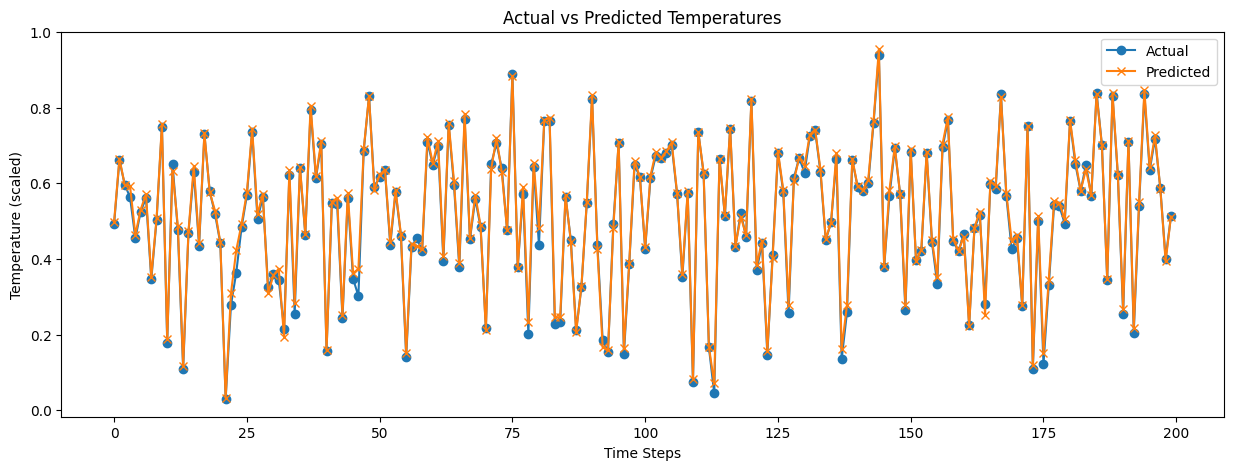

In [58]:
# Validation using chart

def validate_predictions(model, data_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            predictions.extend(outputs.numpy().flatten())
            actuals.extend(labels.numpy().flatten())
    return actuals, predictions


actuals, predictions = validate_predictions(model, data_loader)

# Calculate metrics
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

# Plot actual vs predicted values
plt.figure(figsize=(15, 5))
plt.plot(actuals[:200], label='Actual', marker='o')  # Plot first 200 points for clarity
plt.plot(predictions[:200], label='Predicted', marker='x')
plt.title('Actual vs Predicted Temperatures')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (scaled)')
plt.legend()
plt.show()
    